In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]

In [3]:
import os
import glob

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import cv2

from utils.fat_utils import Scene, Side
from utils import coor_utils, visualize, class_names, cv2_utils
from utils import data as datalib

from misc import fragment, uv_map

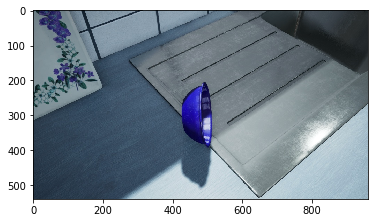

In [4]:
scene = Scene('./fat/single/024_bowl_16k/kitchen_0/', 0)

img = Image.fromarray(scene.left.img.copy())
plt.imshow(img); plt.show()

model_root = './fat/ycb_models_nvdu_aligned_cm/024_bowl//google_512k/'
pts = datalib.load_obj(model_root+'textured.obj')

# Map on 2D image

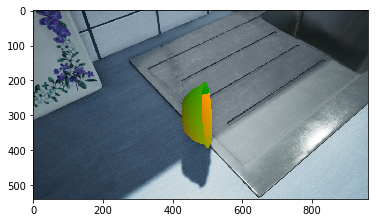

In [5]:
nbins = 256

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

pts_disp = pts[store_dict['depth_sorted_ind'], :]

_img = uv_map.draw_uv_map_image(pts_disp, pts_ind, scene.left.img, method='s', bins=nbins)
plt.imshow(_img)

## UV To XYZ

In [7]:
u_map, v_map = uv_map.generate_uv_map(pts, bins=nbins, to_256=True)
uv2xyz = {}
for i in range(len(u_map)):
    key = (u_map[i], v_map[i])
    uv2xyz[key] = pts[i]
print(len(uv2xyz))

32431


## Do PnP fitting

In [10]:
left = scene.left
mask = left.seg
A = left.intrinsic_matrix[:3, :3]
M_offset = left.offset_matrix
Tmw_true = left.Tmw_list[0]
print("GT Tmw: \n", left.Tmw_list[0])

GT Tmw: 
 [[-8.89525010e-02 -9.80741956e-01  1.73875441e-01 -9.31200027e-01]
 [ 7.44143720e-01  5.05995128e-02  6.66100453e-01  2.62789989e+00]
 [-6.62070674e-01  1.88639619e-01  7.25312014e-01  6.68303986e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [9]:
mask_y, mask_x, _ = np.where(mask == 255)
pts_ind = np.column_stack([mask_x, mask_y])
pts_2d = pts_ind.astype(np.float32)
pts_3d = []
for i in range(len(pts_2d)):
    _i, _j = mask_y[i], mask_x[i]
    key = tuple(_img[_i, _j, :2])
    if key in uv2xyz:
        pts_3d.append(uv2xyz[key])
pts_3d = np.row_stack(pts_3d)

pts_2d = coor_utils.reverse_offset(pts_2d, M_offset).astype(np.float32)
Tmw_est = cv2_utils.transformation_4x4_EPnP(
    pts_3d, pts_2d, A)
print(Tmw_est)

[[-8.42899097e-02 -9.82026054e-01  1.68878773e-01 -1.03965190e+00]
 [ 7.45459664e-01  5.03147372e-02  6.64649017e-01  2.60822149e+00]
 [-6.61199743e-01  1.81915519e-01  7.27819788e-01  6.69721291e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [19]:
print(Tmw_true - Tmw_est)
print(np.linalg.norm(Tmw_est - Tmw_true, ord=1))

[[-0.00466259  0.0012841   0.00499667  0.10845187]
 [-0.00131594  0.00028478  0.00145144  0.0196784 ]
 [-0.00087093  0.0067241  -0.00250777 -0.14173051]
 [ 0.          0.          0.          0.        ]]
0.269860783634317


In [ ]:
# Draw pivots (qualitative analysis)


# UV Map extended With fragments

In [12]:
nbins = 5
nfrags = 3
pcd = uv_map.create_visualization_uvf_point_cloud(
    pts_16k, method='s', uv_bins=nbins, frag_bins=nfrags)
pcd.transform(opencv_to_opengl @ scene.left.Tmw_list[0])
vis = o3d.JVisualizer()
vis.add_geometry(pcd)
vis.show()

JVisualizer with 1 geometries

# Random

In [13]:
nbins = 16

single_root = './fat/single/'
mod = np.random.choice(glob.glob(os.path.join(single_root, '*')))
place = np.random.choice(glob.glob(os.path.join(mod, '*')))
num_scenes = len(glob.glob(os.path.join(place, '*.left.jpg')))
index = np.random.choice(num_scenes)

Model Name:  052_extra_large_clamp


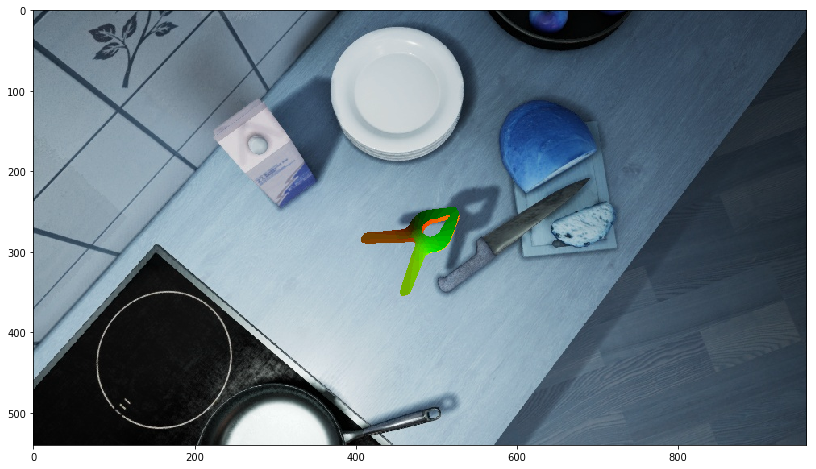

In [14]:
scene = Scene(place, index)
model_name = scene.left.objects[0]['class'].replace('_16k', '').replace('_16K', '')
# model_name = place.split('/')[-2].replace('_16k', '').replace('_16K', '')
model_root = f"./fat/ycb_models_nvdu_aligned_cm/{model_name}/google_512k/"
pts = datalib.load_obj(model_root+'textured.obj')

img = Image.fromarray(scene.left.img.copy())

# Get mapped coordinates
store_dict = dict(depth_sorted_ind=None)
pts_ind = scene.left.transform_point_cloud(pts, ind=0, store_dict=store_dict).astype(int)

_img = uv_map.draw_uv_map_image(
    pts[store_dict['depth_sorted_ind']], pts_ind, scene.left.img, method='s', bins=nbins)
print("Model Name: ", model_name)
plt.imshow(_img);
plt.show()